In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

mnist_train = dset.MNIST('../', train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST('../', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

batch_size = 100
train_loader = DataLoader(mnist_train,batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test,batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw


Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw


Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw


Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,16,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16,32,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(64,128,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2),
        nn.Conv2d(128,256,3,padding=1),
        nn.ReLU()
    )
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size,-1)
    return out

encoder = Encoder().cuda()

In [6]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.layer1 = nn.Sequential(
        nn.UpsamplingBilinear2d(scale_factor=2),
        nn.ConvTranspose2d(256,128,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )
    self.layer2 = nn.Sequential(
        nn.ConvTranspose2d(64,16,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.UpsamplingBilinear2d(scale_factor=2),
        nn.ConvTranspose2d(16,1,3,1,1),
        nn.ReLU()
    )
  def forward(self,x):
    out = x.view(batch_size,256,7,7)
    out = self.layer1(out)
    out = self.layer2(out)
    return out

decoder = Decoder().cuda()

In [7]:
parameters = itertools.chain(encoder.parameters(), decoder.parameters())
loss_func = nn.MSELoss()
optimizer = optim.Adam(parameters, lr=0.0002)

In [9]:
epoch = 10

for i in range(epoch):
  for j,(img,label) in enumerate(train_loader):
    optimizer.zero_grad()

    img = img.cuda()
    z = encoder(img)
    output = decoder(z)
    loss = loss_func(output,img)

    loss.backward()
    optimizer.step()

  print('loss is', loss.cpu().item())

loss is 0.010835974477231503
loss is 0.007919074036180973
loss is 0.0062867277301847935
loss is 0.005014325026422739
loss is 0.005532237235456705
loss is 0.00412145908921957
loss is 0.003524140687659383
loss is 0.0034478676971048117
loss is 0.0033580041490495205
loss is 0.002981515135616064


torch.Size([100, 28, 28])


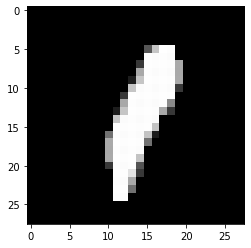

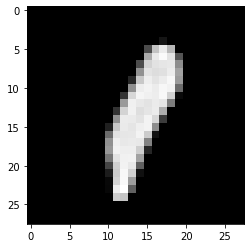

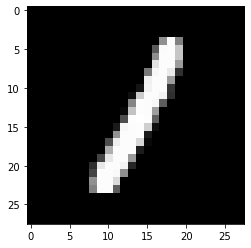

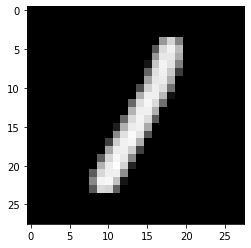

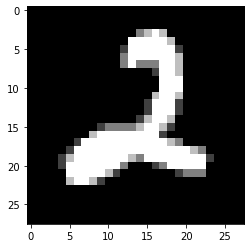

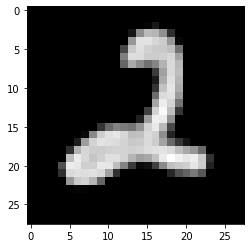

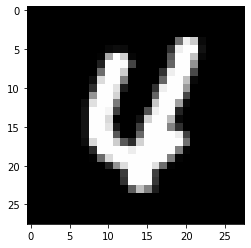

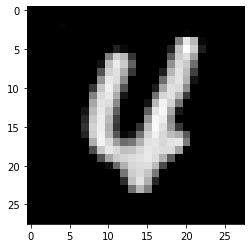

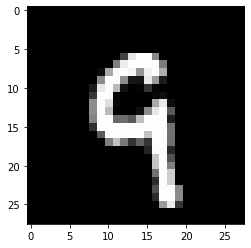

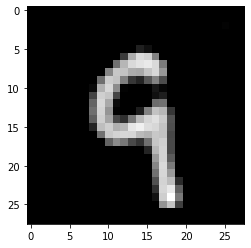

In [12]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
  plt.imshow(img[i].cpu().squeeze().numpy(),cmap='gray')
  plt.show()
  plt.imshow(out_img[i].numpy(),cmap='gray')
  plt.show()

In [13]:
for i in range(1):
  for j,(img,label) in enumerate(test_loader):

    img = img.cuda()
    z = encoder(img)
    output = decoder(z)

  print('loss is', loss.cpu().item())

loss is 0.002981515135616064


torch.Size([100, 28, 28])


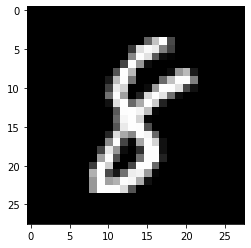

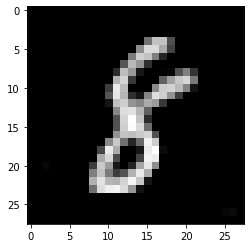

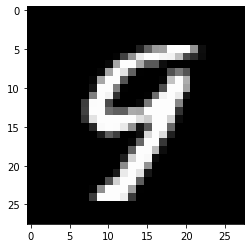

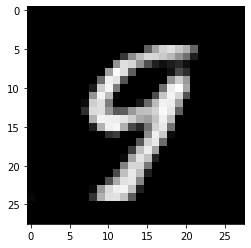

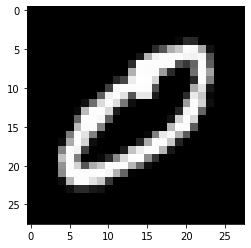

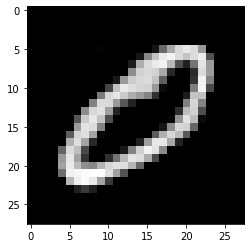

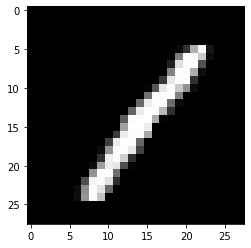

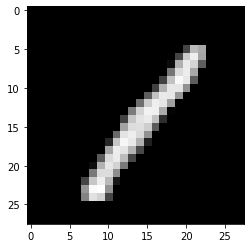

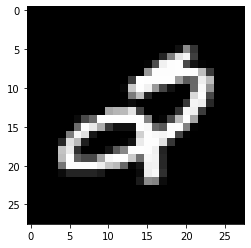

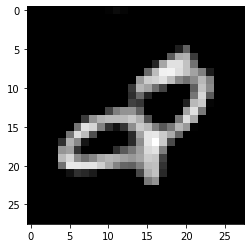

In [19]:
out_img = output.cpu().data.squeeze()
print(out_img.size())

for i in range(5):
  plt.imshow(torch.squeeze(img[i].cpu()).data.numpy(),cmap='gray')
  plt.show()
  plt.imshow(out_img[i].numpy(),cmap='gray')
  plt.show()